# Exploring San Francisco Restaurant Score Data

For detailed information about the dataset, please visit [their official website](https://data.sfgov.org/Health-and-Social-Services/Restaurant-Scores-LIVES-Standard/pyih-qa8i).

### Downloading the data file

First we send a HTTP GET request and fetch the data

In [1]:
import requests

download_file = requests.get('https://data.sfgov.org/api/views/rkru-6vcg/rows.csv?accessType=DOWNLOAD')
if download_file.status_code != 200:
    print('Error while fetching the data')
else:
    print('Data successfully received')

Data successfully received


Let's look at the location where this data will be saved.

In [2]:
import os
import sys

filename = os.path.join(os.path.dirname(sys.argv[0]), download_file.headers['content-disposition'].split(';')[-1].strip().split('=')[-1])
print('Data will be saved in: ' + filename)

Data will be saved in: c:\users\sudip.a.banerjee\pycharmprojects\learning\venv\lib\site-packages\Air_Traffic_Passenger_Statistics.csv


Now we save the data in a CSV file

In [3]:
op_file = open(filename, 'wb')
op_file.write(download_file.content)
op_file.close()

Let's see the top 5 rows of the file

In [4]:
file = open(filename, 'r')
for _ in range(5):
    print(file.readline())
file.close()

Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count

200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271

200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131

200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415

200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156



### Reading the file in Pandas

In [490]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [6]:
df = pd.read_csv(filename)

In [7]:
df.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271
1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415
3,200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156
4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,34090


In [8]:
df['Activity Period'] = pd.to_datetime(df['Activity Period'], format='%Y%m')

In [200]:
print(df['Activity Period'].min())
print(df['Activity Period'].max())

2005-07-01 00:00:00
2020-03-01 00:00:00


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22120 entries, 0 to 22119
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Activity Period              22120 non-null  datetime64[ns]
 1   Operating Airline            22120 non-null  object        
 2   Operating Airline IATA Code  22057 non-null  object        
 3   Published Airline            22120 non-null  object        
 4   Published Airline IATA Code  22057 non-null  object        
 5   GEO Summary                  22120 non-null  object        
 6   GEO Region                   22120 non-null  object        
 7   Activity Type Code           22120 non-null  object        
 8   Price Category Code          22120 non-null  object        
 9   Terminal                     22120 non-null  object        
 10  Boarding Area                22120 non-null  object        
 11  Passenger Count              22120 non-nu

In [10]:
df['Operating Airline'].replace({'United Airlines - Pre 07/01/2013': 'United Airlines'}, inplace=True)
df['Published Airline'].replace({'United Airlines - Pre 07/01/2013': 'United Airlines'}, inplace=True)

Operating Airline vs Time

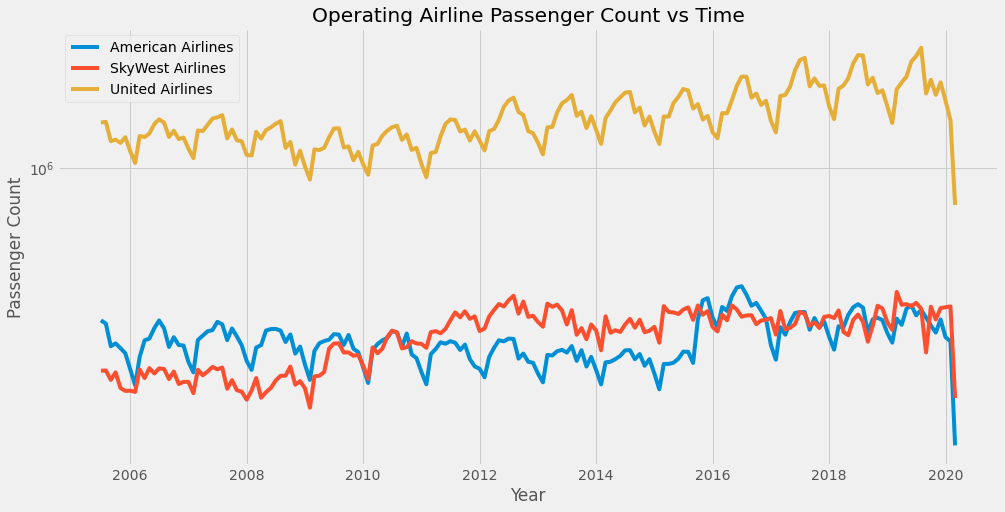

In [164]:
%matplotlib inline
popular_airlines = df[['Operating Airline', 'Passenger Count']]\
                        .sort_values(by='Operating Airline')\
                        .groupby('Operating Airline')\
                        .sum()\
                        .sort_values(by='Passenger Count', ascending=False)\
                        .head(3)\
                        .index\
                        .to_list()
op = df.loc[df['Operating Airline'].isin(popular_airlines), ['Activity Period', 'Operating Airline', 'Passenger Count']]\
        .sort_values(by=['Activity Period', 'Operating Airline'])\
        .groupby(['Activity Period', 'Operating Airline'])\
        .sum()\
        .reset_index()\
        .pivot(index='Activity Period', columns='Operating Airline', values='Passenger Count')\
        .fillna(0)

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [15, 7.5]
lines = plt.plot(op.index, op)
plt.yscale('log')
plt.legend(lines, op.columns.to_list(), loc='upper left')
plt.title('Operating Airline Passenger Count vs Time')
plt.xlabel('Year')
plt.ylabel('Passenger Count')
plt.show()

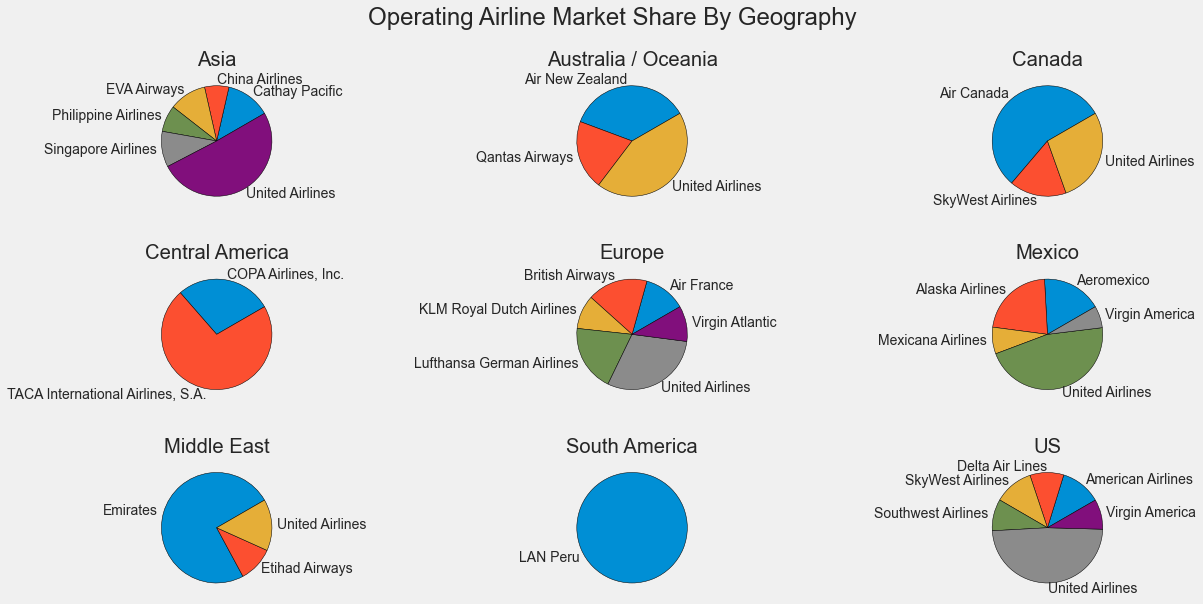

In [467]:
%matplotlib inline
op = df[['GEO Region', 'Operating Airline', 'Passenger Count']]\
        .sort_values(by=['GEO Region', 'Operating Airline'])\
        .groupby(['GEO Region', 'Operating Airline'])\
        .sum()\
        .reset_index()\
        .pivot(index='GEO Region', columns='Operating Airline', values='Passenger Count')\
        .fillna(0)

plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(3, 3, figsize=(18, 9))
for row_num, (idx, row) in enumerate(op.iterrows()):
    ax = axes[row_num // 3, row_num % 3]
    row = row[row.gt(row.sum() * .05)]
    ax.pie(row, labels=row.index, startangle=30, wedgeprops={'edgecolor': 'black'})
    ax.set_title(idx)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Operating Airline Market Share By Geography', fontsize=24)
plt.show()

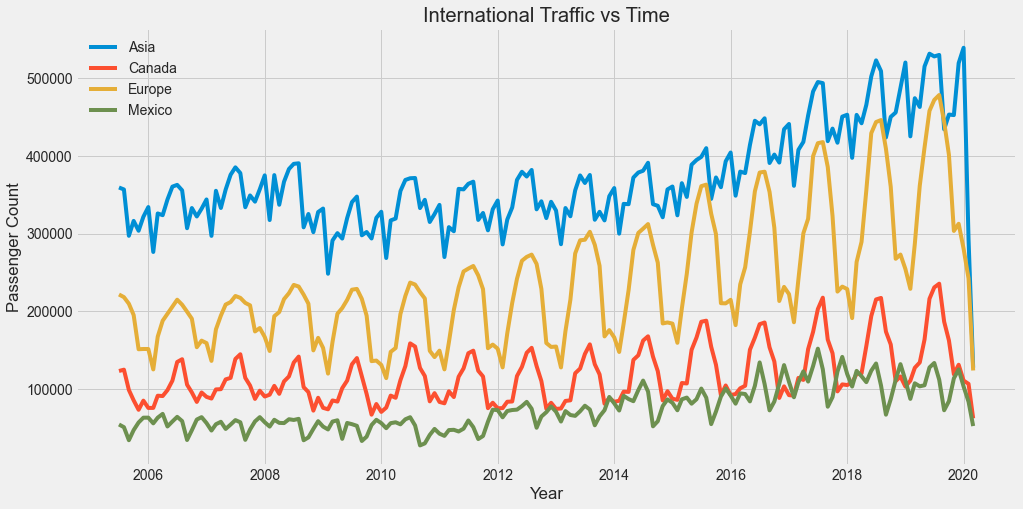

In [306]:
%matplotlib inline
op = df.loc[df['GEO Summary'] == 'International', ['Activity Period', 'GEO Region', 'Passenger Count']]\
        .sort_values(by=['Activity Period', 'GEO Region'])\
        .groupby(['Activity Period', 'GEO Region'])\
        .sum()\
        .reset_index()
op['Rank'] = op.groupby('Activity Period')['Passenger Count'].rank(method='dense', ascending=False)
top_regions = op.loc[op['Rank'] <= 3, 'GEO Region'].unique()
op = op.loc[op['GEO Region'].isin(top_regions), 'Activity Period':'Passenger Count']\
        .reset_index(drop=True)\
        .pivot(index='Activity Period', columns='GEO Region', values='Passenger Count')\
        .fillna(0)

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.legend(lines, op.columns.to_list(), loc='upper left')
plt.title('International Traffic vs Time')
plt.xlabel('Year')
plt.ylabel('Passenger Count')
lines = plt.plot(op.index, op)
plt.show()

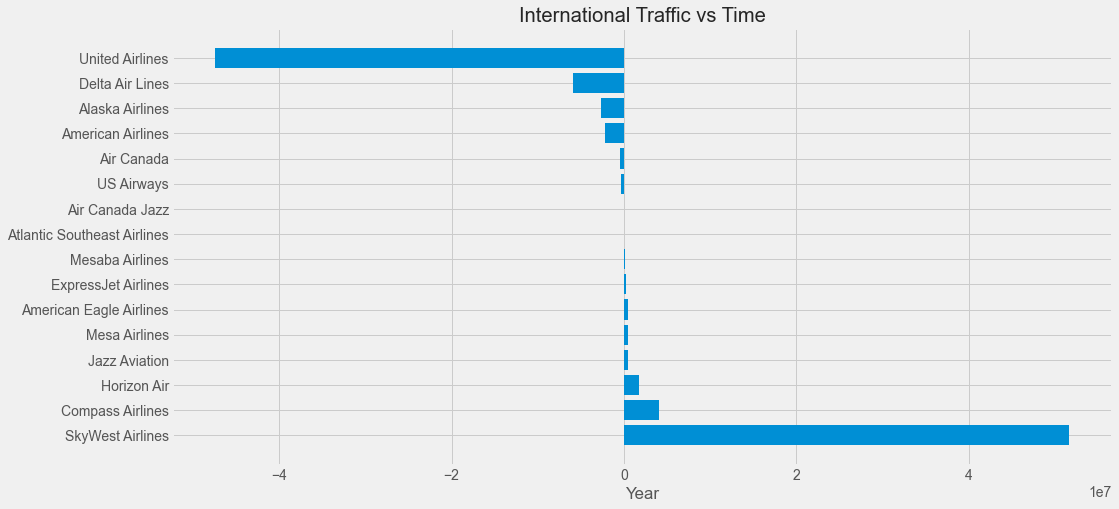

In [506]:
operatied_df = df[['Operating Airline', 'Passenger Count']]\
                    .sort_values(by='Operating Airline')\
                    .groupby('Operating Airline')\
                    .sum()\
                    .reset_index()\
                    .rename(columns={'Operating Airline': 'Airline', 'Passenger Count': 'Operated Passenger Count'})
published_df = df[['Published Airline', 'Passenger Count']]\
                    .sort_values(by='Published Airline')\
                    .groupby('Published Airline')\
                    .sum()\
                    .reset_index()\
                    .rename(columns={'Published Airline': 'Airline', 'Passenger Count': 'Published Passenger Count'})
op = operatied_df.merge(published_df, how='outer', on='Airline').set_index('Airline').fillna(0)
op['Difference'] = op['Operated Passenger Count'].subtract(op['Published Passenger Count'])
op = op.loc[op['Difference'] != 0].sort_values(by='Difference', ascending=False)

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.title('International Traffic vs Time')
plt.xlabel('Year')
plt.barh(op.index, op['Difference'])
plt.show()

In [489]:
import numpy as np
np.arange(5)

array([0, 1, 2, 3, 4])